<a href="https://colab.research.google.com/github/tumblingdice512/Research/blob/master/model5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [213]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [214]:
N = 10
L = 5

In [215]:
import numpy as np
np.random.seed(100)

In [216]:
S0 = torch.sign(torch.randn(9,N))

SL = torch.sign(torch.randn(9,N))


M = S0.size()[0]
print(M)
print(N)
print(S0.shape)
print(S0[0].shape)

9
10
torch.Size([9, 10])
torch.Size([10])


In [217]:
alpha = M / N
print(alpha)

0.9


In [218]:
D = torch.Tensor([[1,2,3],[2,3,4]])
print(D)
print(D.shape)
print("M:",D.size()[0]) #M
print("N:",D.size()[1]) #N

tensor([[1., 2., 3.],
        [2., 3., 4.]])
torch.Size([2, 3])
M: 2
N: 3


In [219]:
def spin_overlap(x,y):
  spin_overlap = 0
  for i in range (len(x[0])) :

    spin_overlap = spin_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(spin_overlap/(x.size()[0]*x.size()[1]))

print(spin_overlap(S0,S0))


tensor(1.)


In [220]:
def bond_overlap(x,y):
  bond_overlap = 0
  for i in range (len(x[0])) :

    bond_overlap = bond_overlap + torch.dot(x.T[i],y.T[i])
  return torch.abs(bond_overlap/(x.size()[0]*x.size()[1]))

In [221]:
S_a = torch.Tensor([[1,-1],[-1,1],[1,-1]])
S_b = torch.Tensor([[1,-1],[1,1],[1,1]])
print(spin_overlap(S_a,S_b))
print(spin_overlap(S_a,S_a))

tensor(0.3333)
tensor(1.)


In [222]:
a1 = torch.dot(S_a.T[0],S_b.T[0])
a2 = torch.dot(S_a.T[1],S_b.T[1])
a3 = (a1 + a2)/(2*3)
print(a3)

tensor(0.3333)


In [223]:
def MSE(t, y):
    mse = torch.mean(torch.sum(torch.square(t-y),axis = 1),axis = 0)
    return mse

In [224]:
print(MSE(S0,SL))

tensor(19.5556)


In [225]:
A = torch.Tensor([[3,5,1],[4,12,1]])
print(A**2)
A_norm = (torch.sum(torch.square(A),axis=0))**(1/2)

A_normalized = A / A_norm
A_normalized_2 = A / A_norm * (N**(1/2))

print(A_norm)

print(A_normalized)
print(A_normalized_2)

tensor([[  9.,  25.,   1.],
        [ 16., 144.,   1.]])
tensor([ 5.0000, 13.0000,  1.4142])
tensor([[0.6000, 0.3846, 0.7071],
        [0.8000, 0.9231, 0.7071]])
tensor([[1.8974, 1.2163, 2.2361],
        [2.5298, 2.9190, 2.2361]])


In [226]:
def weight_norm(x):
    x_norm = (torch.sum(torch.square(x),axis=0)**(1/2))
    return x_norm

In [227]:
w_a = torch.Tensor([[1,0,1],[1,0,0],[0,1,0]]) 
w_b = torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]) 
J_a = w_a / (weight_norm(w_a)) * (3**(1/2))
J_b = w_b / (weight_norm(w_b)) * (3**(1/2))


print(J_a)
print(J_b)
print(len(J_a[0]))

print(bond_overlap(J_a,J_b))
print(bond_overlap(J_a,J_a))

tensor([[1.2247, 0.0000, 1.7321],
        [1.2247, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000]])
tensor([[1.7321, 0.0000, 0.0000],
        [0.0000, 1.7321, 0.0000],
        [0.0000, 0.0000, 1.7321]])
3
tensor(0.2357)
tensor(1.)


In [228]:

c = torch.nn.utils.weight_norm(torch.nn.Linear(4, 3, False), name='weight',dim=0)
#計算の際にはcの転置を用いる。正規化は、dim=0で行う必要あり。
print(c.weight)
print(c.weight_g)
d = c.weight/c.weight_g
print(d)
print(c.weight_v.size())

tensor([[ 0.3817,  0.3099, -0.1436, -0.1612],
        [-0.3713,  0.4988,  0.3335,  0.3429],
        [-0.3468,  0.2268,  0.4870, -0.3599]], grad_fn=<MulBackward0>)
Parameter containing:
tensor([[0.5370],
        [0.7845],
        [0.7337]], requires_grad=True)
tensor([[ 0.7108,  0.5772, -0.2674, -0.3002],
        [-0.4732,  0.6358,  0.4251,  0.4371],
        [-0.4726,  0.3090,  0.6638, -0.4905]], grad_fn=<DivBackward0>)
torch.Size([3, 4])


In [229]:
print(torch.dot(torch.tensor([-0.7766,  0.1530,  0.4038, -0.4588]),torch.tensor([-0.7766,  0.1530,  0.4038, -0.4588]))**(1/2))

tensor(1.0000)


In [230]:
print(torch.dot(torch.tensor([-0.0904, -0.2665,  0.3962, -0.8740]),torch.tensor([-0.0904, -0.2665,  0.3962, -0.8740]))**(1/2))

tensor(1.0000)


In [231]:
print(torch.dot(torch.tensor([-0.6091, -0.4947,  0.6101,  0.1093]),torch.tensor([-0.6091, -0.4947,  0.6101,  0.1093]))**(1/2))

tensor(0.9999)


In [232]:
class Network1(torch.nn.Module):
    def __init__(self):
        super(Network1, self).__init__()
        self.fc1_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc2_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc3_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc4_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)
        self.fc5_1 = torch.nn.utils.weight_norm(torch.nn.Linear(N, N, False), name='weight',dim=0)

        
    def forward(self, x):
        x = torch.tanh(self.fc1_1(x))
        S1_1 = torch.sign(x)
        x = torch.tanh(self.fc2_1(x))
        S2_1 = torch.sign(x)
        x = torch.tanh(self.fc3_1(x))
        S3_1 = torch.sign(x)
        x = torch.tanh(self.fc4_1(x))
        S4_1 = torch.sign(x)
        x = torch.tanh(self.fc5_1(x))
        S5_1 = torch.sign(x)

        return x, S1_1, S2_1, S3_1, S4_1, S5_1, self.fc1_1, self.fc2_1, self.fc3_1, self.fc4_1, self.fc5_1, self.fc1_1.weight_g, self.fc2_1.weight_g, self.fc3_1.weight_g, self.fc4_1.weight_g, self.fc5_1.weight_g



In [233]:
if __name__ == '__main__':
    # 学習回数
    n_epoch = 5000
 
    # 学習結果の保存用
    history = {
        'train_loss_1': [],
    }
 
    # ネットワークを構築
    net: torch.nn.Module = Network1()
 
    optimizer = torch.optim.SGD(params=net.parameters(), lr=0.01)
 
    for n in range(n_epoch):
 
        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  # 引数は省略可能
 
        optimizer.zero_grad()
        output = net(S0)
        loss = MSE(output[0], SL)
        #loss_function = torch.nn.MSELoss()
        #loss = loss_function(output[0], SL)
        loss.backward()
        optimizer.step()
 
        print('EPOCH ', n + 1, ' | train_loss_1 ',loss)
        
 
        history['train_loss_1'].append(loss)


EPOCH  1  | train_loss_1  tensor(10.0171, grad_fn=<MeanBackward1>)
EPOCH  2  | train_loss_1  tensor(10.0030, grad_fn=<MeanBackward1>)
EPOCH  3  | train_loss_1  tensor(9.9890, grad_fn=<MeanBackward1>)
EPOCH  4  | train_loss_1  tensor(9.9753, grad_fn=<MeanBackward1>)
EPOCH  5  | train_loss_1  tensor(9.9617, grad_fn=<MeanBackward1>)
EPOCH  6  | train_loss_1  tensor(9.9482, grad_fn=<MeanBackward1>)
EPOCH  7  | train_loss_1  tensor(9.9349, grad_fn=<MeanBackward1>)
EPOCH  8  | train_loss_1  tensor(9.9217, grad_fn=<MeanBackward1>)
EPOCH  9  | train_loss_1  tensor(9.9085, grad_fn=<MeanBackward1>)
EPOCH  10  | train_loss_1  tensor(9.8954, grad_fn=<MeanBackward1>)
EPOCH  11  | train_loss_1  tensor(9.8823, grad_fn=<MeanBackward1>)
EPOCH  12  | train_loss_1  tensor(9.8692, grad_fn=<MeanBackward1>)
EPOCH  13  | train_loss_1  tensor(9.8561, grad_fn=<MeanBackward1>)
EPOCH  14  | train_loss_1  tensor(9.8429, grad_fn=<MeanBackward1>)
EPOCH  15  | train_loss_1  tensor(9.8298, grad_fn=<MeanBackward1>)
EP

{'train_loss_1': [tensor(10.0171, grad_fn=<MeanBackward1>), tensor(10.0030, grad_fn=<MeanBackward1>), tensor(9.9890, grad_fn=<MeanBackward1>), tensor(9.9753, grad_fn=<MeanBackward1>), tensor(9.9617, grad_fn=<MeanBackward1>), tensor(9.9482, grad_fn=<MeanBackward1>), tensor(9.9349, grad_fn=<MeanBackward1>), tensor(9.9217, grad_fn=<MeanBackward1>), tensor(9.9085, grad_fn=<MeanBackward1>), tensor(9.8954, grad_fn=<MeanBackward1>), tensor(9.8823, grad_fn=<MeanBackward1>), tensor(9.8692, grad_fn=<MeanBackward1>), tensor(9.8561, grad_fn=<MeanBackward1>), tensor(9.8429, grad_fn=<MeanBackward1>), tensor(9.8298, grad_fn=<MeanBackward1>), tensor(9.8165, grad_fn=<MeanBackward1>), tensor(9.8032, grad_fn=<MeanBackward1>), tensor(9.7898, grad_fn=<MeanBackward1>), tensor(9.7762, grad_fn=<MeanBackward1>), tensor(9.7625, grad_fn=<MeanBackward1>), tensor(9.7487, grad_fn=<MeanBackward1>), tensor(9.7347, grad_fn=<MeanBackward1>), tensor(9.7205, grad_fn=<MeanBackward1>), tensor(9.7061, grad_fn=<MeanBackward1

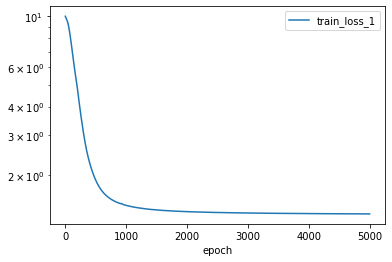

In [234]:
# 結果の出力と描画
print(history)
plt.figure()
plt.plot(range(1, n_epoch+1), history['train_loss_1'], label='train_loss_1')
plt.xlabel('epoch')
plt.legend()
plt.yscale("log")
plt.savefig('loss.png')



In [235]:
print(spin_overlap(output[5], SL))

tensor(0.8667, grad_fn=<AbsBackward>)


In [236]:
print(output[12])

Parameter containing:
tensor([[0.7311],
        [0.9289],
        [1.2235],
        [1.1261],
        [1.1054],
        [0.6126],
        [1.1800],
        [1.2836],
        [1.1398],
        [0.9969]], requires_grad=True)


In [258]:
#print(output[7].weight)
J1_1 = N**(1/2) * output[6].weight/output[11]
J2_1 = N**(1/2) * output[7].weight/output[12]
J3_1 = N**(1/2) * output[8].weight/output[13]
J4_1 = N**(1/2) * output[9].weight/output[14]
J5_1 = N**(1/2) * output[10].weight/output[15]

In [260]:
spin_overlap(J1_1,J1_1)

tensor(1.0000, grad_fn=<AbsBackward>)

In [246]:
print(J1_1[0])
print(output[7].weight_g)
print(output[7].weight[0])

tensor([-0.5791, -2.0592, -1.7123,  0.4327,  0.3482,  0.7834,  1.0680,  0.1333,
         0.3991,  0.5024], grad_fn=<SelectBackward>)
Parameter containing:
tensor([[0.7311],
        [0.9289],
        [1.2235],
        [1.1261],
        [1.1054],
        [0.6126],
        [1.1800],
        [1.2836],
        [1.1398],
        [0.9969]], requires_grad=True)
tensor([-0.1339, -0.4761, -0.3959,  0.1000,  0.0805,  0.1811,  0.2469,  0.0308,
         0.0923,  0.1161], grad_fn=<SelectBackward>)


In [251]:
print(torch.dot(torch.tensor([-0.8973, -0.0664,  0.5579, -0.2825,  0.4563, -0.5632,  1.6983,  2.3204,
         -0.0137,  0.0725]),torch.tensor([-0.8973, -0.0664,  0.5579, -0.2825,  0.4563, -0.5632,  1.6983,  2.3204,
         -0.0137,  0.0725])))

tensor(9.9999)


0.53450721
